# Correlating two timeseries, using HF radar data

In [2]:
# Import Libraries
import numpy as np
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
import matplotlib.pyplot as plt
import datetime

In [3]:
# Load the HF radar data in netCDF format, downloaded from AODN
hfr_data = Dataset('output.nc')

In [4]:
# Get time units, calendar used, and convert from num to date
units = hfr_data.variables['TIME'].units
calendar = hfr_data.variables['TIME'].calendar
t = num2date(hfr_data.variables['TIME'][:], units=units, calendar=calendar)

In [5]:
# Assign Variables
u = hfr_data.variables['UCUR'][:,:,:]
v = hfr_data.variables['VCUR'][:,:,:]
lon = hfr_data.variables['LONGITUDE'][:]
lat = hfr_data.variables['LATITUDE'][:]
s = (u**2 + v**2)**0.5

In [6]:
# What are the dimensions?
np.shape(u), np.shape(lat), np.shape(lon)

((409, 167, 114), (167,), (114,))

In [7]:
# Take a look at the time coverage
amt = np.isfinite(v) # get boolean if a number
utot = amt.sum(axis=0) # count how much data
# dplot = utot/utot.max()*100 # get data coverage as a percent, normalized by max coverage
dplot = utot/len(t)*100 # get data coverage as a percent over the time period

Text(0.5,1,'Percentage of Data Returns')

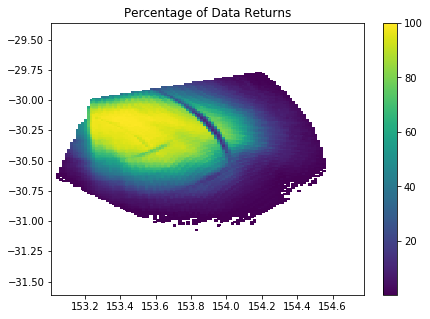

In [8]:
plt.figure(figsize=(7,5))
plt.pcolor(lon,lat,dplot), plt.colorbar()
plt.title('Percentage of Data Returns')

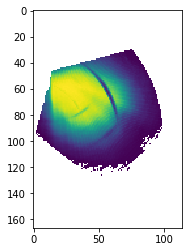

In [9]:
plt.imshow(dplot) # for manually choosing the grid points to correlate (i.e. want to pick a good coverage region)

In [10]:
# Choose 2 grid points to correlate in V
latIndex = 70 # chosen subjectively based on plot above
lonIndex1 = 20 # chosen subjectively based on plot above
lonIndex2 = 30 # chosen subjectively based on plot above

v1 = v[:,latIndex,lonIndex1] # one near shore
v2 = v[:,latIndex,lonIndex2] # one further offshore

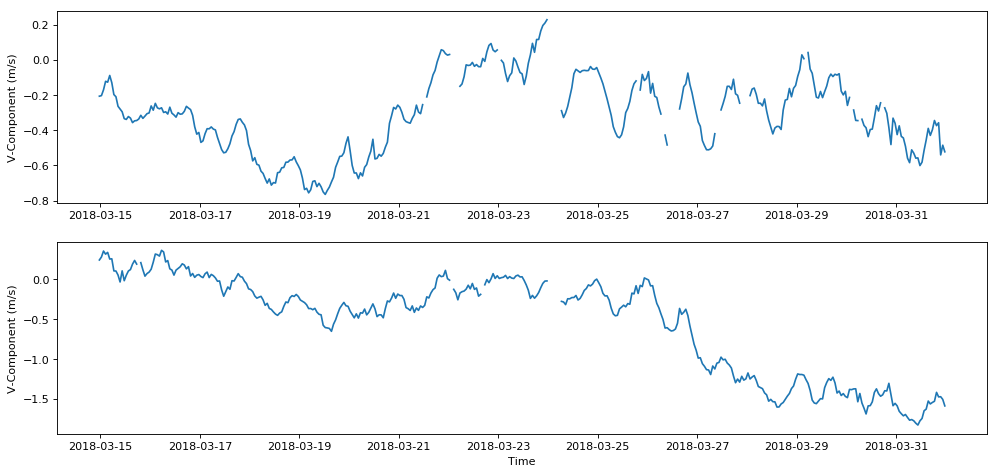

In [11]:
# Plot Timeseries of the two chosen grid points
figure1 = plt.figure(figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(211)
plt.plot(t,v1)
plt.ylabel('V-Component (m/s)')

plt.subplot(212)
plt.plot(t,v2)
plt.ylabel('V-Component (m/s)')
plt.xlabel('Time')

plt.show()

In [12]:
type(v1), type(v2) # What are the data types?

(numpy.ma.core.MaskedArray, numpy.ma.core.MaskedArray)

In [13]:
np.corrcoef(v1,v2) # Correlate!

array([[1.        , 0.42132162],
       [0.42132162, 1.        ]])

So we find the correlation between the two timeseries is 0.42, which is quite low. This is likely due to the distance offshore. If we looked at two grid points at the same longitude and different latitudes we would likely find much higher correlations.

In [22]:
np.shape(t[1:]), np.shape(t[0:-1]), np.shape(t)

((408,), (408,), (409,))

In [30]:
# Grab the timeseries as a numerical float value
time=hfr_data.variables['TIME'][:]
type(time), type(t)

(numpy.ndarray, numpy.ndarray)

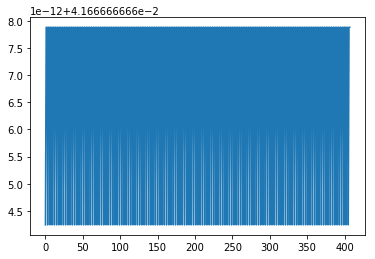

In [29]:
# Check the spacing in time
plt.plot(time[1:]-time[0:-1])
# print(t)

In [40]:
# Subsample by half 
timeI = time[0:-1:2]

In [44]:
# Confirm shape
np.shape(timeI)

(204,)

In [45]:
# Interpolate the full timeseries of v1 onto the half resolution timeseries timeI
vi = np.interp(timeI,time,v1)

(-0.8, 0.5)

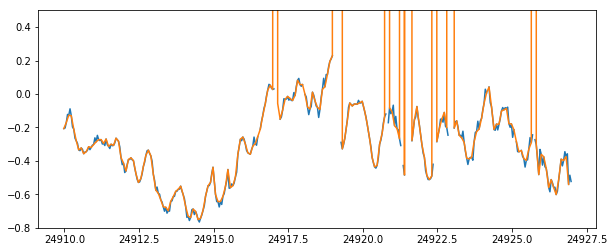

In [49]:
# Check with a plot
plt.figure(figsize=(10,4))
plt.plot(time,v1)
plt.plot(timeI,vi)
plt.ylim(-.8,.5)

As you can see from the figure, where there were gaps in the timeseries, the interpolation function has filled with suprious values, so next we need to remove these data points where there was no original data...

In [57]:
# I.e. mask array where v1 has no data (note we have to make sure they have the same size for this to work)
vi2 = np.ma.masked_where(np.isnan(v1[0:-1:2]),vi)

(-0.8, 0.5)

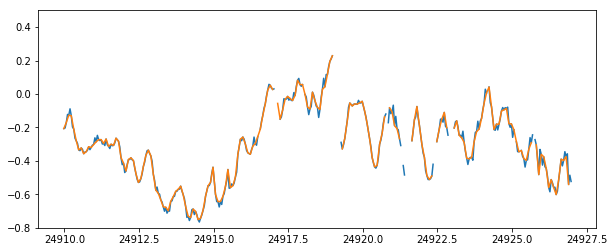

In [58]:
# Check with a plot
plt.figure(figsize=(10,4))
plt.plot(time,v1)
plt.plot(timeI,vi2)
plt.ylim(-.8,.5)